# Notebook that computes Shapiro delay from galaxy cluster catalogs

Written for Python2 (2.7.12)

Author: Olivier Minazzoli

Date (yymmdd): 190723

This code generates the plots in FIG. 1 of the manuscript LIGO-P1900149

Details of the computation in Shapiro_main_code_TABLE1_FIG2.ipynb

Code tested with matplotlib 2.1.2, 2.2.3 and 2.2.4. Plotting issues were found with version 1.5.1.

In [1]:
# Import scientific package numpy
import numpy as np
#Import I/O packages
from io import BytesIO
# Import package to deal with astronomical coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
# Import plotting package
import matplotlib.pyplot as plt

In [2]:
# Import constants from LAL 
from lal import PC_SI, C_SI, G_SI, MSUN_SI

### Skymap at various distances

In [3]:
# Create RA and DEC vectors corresponding to sources uniformly distributed in the sky

# Rseolution of the skymap: (takes a few hours with the good resolution)
#interval = 2.         # Interval defining the resolution (2 => high resolution)
interval = 5.         # Interval defining the resolution (5 => good resolution)
#interval = 10.         # Interval defining the resolution (10 => low resolution)

sourceRA = np.arange(0,360,interval)
sourceDEC = np.arange(-90,90,interval/2.)
if len(sourceDEC) != len(sourceRA):
    print 'Warning: array size incompatible between RA and DEC'

# Set array of positions in the sky
array_B = np.empty([0,2]) 
for i in range(int(360/interval)):
    for j in range(int(180/interval)):
        array_B = np.insert(array_B, 0, [i*interval, j*interval-90], axis = 0)
       
    
# Range of distances considered and interval between each of them

dinterval = 10
min_dis = 10
max_dis = 400

## Tempel 2016

In [4]:
# Define name of file to be called
catalog = 'tempel2016_cata_full'   # must be in 'catalogs_data/%s.dat' 

# Read the file where the characteristics of the gravitational sources of the catalog are given: ra, dec, distance (Mpc), Mass

cata = np.genfromtxt('catalogs_data/%s.out' % catalog, comments ='#')

Nbr_sources = cata.shape[0]     # Number of sources in the catalog

# Rewrite file without rows with null mass (happends (e.g.) when not enough objects to infer mass from Virial theorem)
cata_wo0 = np.empty([0,4])      # set new array of data
for i in range(Nbr_sources):
    if cata[i , 3] != 0:
        cata_wo0 = np.insert(cata_wo0, 0, cata[i], axis = 0)

Nbr_sources_wo0 = cata_wo0.shape[0]     # Number of sources in the catalog without zero mass

# Set vectors for computation
cataRA = cata_wo0[:, 0]             # Vector with all RA coordinates from catalog
cataDEC = cata_wo0[:, 1]            # Vector with all DEC coordinates from catalog
cataDIS = cata_wo0[:, 2]            # Vector with all distances from catalog
cataMASS = cata_wo0[:, 3]           # Vector with all masses from catalog

In [5]:
dt_Shapiro_mean_tempel = np.empty([0,2]) 

for d_L in range(min_dis,max_dis,dinterval):
    # Set array of vector pointing toward the source of the waves,
    vec_B = SkyCoord(ra = array_B[:,0]*u.degree, dec = array_B[:,1]*u.degree, distance = d_L*u.mpc)
    size_vec_B = len(vec_B)
    # Set array of vector pointing toward each cluster
    vec = SkyCoord(ra=cataRA*u.degree, dec=cataDEC*u.degree, distance=cataDIS*u.mpc) # Coordinate array
    #######
    dt_Shapiro = np.empty([0,3]) 
    for i in range(size_vec_B):
        theta_A = vec_B[i].separation(vec).rad # angle between source and line of sight
        r_B = vec_B[i].separation_3d(vec).mpc
        #cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.)] # wrong equation found in literature
        cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))-d_L/ cataDIS - 0.5 * (d_L/ cataDIS)**2. * np.cos(theta_A))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.), cataMASS] # Equation with appropriate gauge
        dt_Shapiro = np.insert(dt_Shapiro, 0, [vec_B[i].ra.degree,vec_B[i].dec.degree,np.sum(cata_shapiro[:,3])], axis = 0)
    ######
    
    dt_Shapiro_mean_tempel = np.insert(dt_Shapiro_mean_tempel, 0, [d_L, np.mean(dt_Shapiro[:,2])], axis = 0) # keep track of the evolution of the mean Shapiro value at each d_L

## Tully2015 (virial)

In [6]:
# Define name of file to be called
catalog = 'tully2015_cata_Mvir_icrs'   # must be in 'catalogs_data/%s.dat' 

# Read the file where the characteristics of the gravitational sources of the catalog are given: ra, dec, distance (Mpc), Mass

cata = np.genfromtxt('catalogs_data/%s.out' % catalog, comments ='#')

Nbr_sources = cata.shape[0]     # Number of sources in the catalog

# Rewrite file without rows with null mass (happends (e.g.) when not enough objects to infer mass from Virial theorem)
cata_wo0 = np.empty([0,4])      # set new array of data
for i in range(Nbr_sources):
    if cata[i , 3] != 0:
        cata_wo0 = np.insert(cata_wo0, 0, cata[i], axis = 0)

Nbr_sources_wo0 = cata_wo0.shape[0]     # Number of sources in the catalog without zero mass

# Set vectors for computation
cataRA = cata_wo0[:, 0]             # Vector with all RA coordinates from catalog
cataDEC = cata_wo0[:, 1]            # Vector with all DEC coordinates from catalog
cataDIS = cata_wo0[:, 2]            # Vector with all distances from catalog
cataMASS = cata_wo0[:, 3]           # Vector with all masses from catalog

In [7]:
dt_Shapiro_mean_cata1 = np.empty([0,2]) 

for d_L in range(min_dis,max_dis,dinterval):
    # Set array of vector pointing toward the source of the waves,
    vec_B = SkyCoord(ra = array_B[:,0]*u.degree, dec = array_B[:,1]*u.degree, distance = d_L*u.mpc)
    size_vec_B = len(vec_B)
    # Set array of vector pointing toward each cluster
    vec = SkyCoord(ra=cataRA*u.degree, dec=cataDEC*u.degree, distance=cataDIS*u.mpc) # Coordinate array
    #######
    dt_Shapiro = np.empty([0,3]) 
    for i in range(size_vec_B):
        theta_A = vec_B[i].separation(vec).rad # angle between source and line of sight
        r_B = vec_B[i].separation_3d(vec).mpc
        #cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.)] # wrong equation found in literature
        cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))-d_L/ cataDIS - 0.5 * (d_L/ cataDIS)**2. * np.cos(theta_A))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.), cataMASS] # Equation with appropriate gauge
        dt_Shapiro = np.insert(dt_Shapiro, 0, [vec_B[i].ra.degree,vec_B[i].dec.degree,np.sum(cata_shapiro[:,3])], axis = 0)
    ######
    
    dt_Shapiro_mean_cata1 = np.insert(dt_Shapiro_mean_cata1, 0, [d_L, np.mean(dt_Shapiro[:,2])], axis = 0) # keep track of the evolution of the mean Shapiro value at each d_L

## Tully2015 (lum)

In [8]:
# Define name of file to be called
catalog = 'tully2015_cata_Mlum_icrs'   # must be in 'catalogs_data/%s.dat' 

# Read the file where the characteristics of the gravitational sources of the catalog are given: ra, dec, distance (Mpc), Mass

cata = np.genfromtxt('catalogs_data/%s.out' % catalog, comments ='#')

Nbr_sources = cata.shape[0]     # Number of sources in the catalog

# Rewrite file without rows with null mass (happends (e.g.) when not enough objects to infer mass from Virial theorem)
cata_wo0 = np.empty([0,4])      # set new array of data
for i in range(Nbr_sources):
    if cata[i , 3] != 0:
        cata_wo0 = np.insert(cata_wo0, 0, cata[i], axis = 0)

Nbr_sources_wo0 = cata_wo0.shape[0]     # Number of sources in the catalog without zero mass

# Set vectors for computation
cataRA = cata_wo0[:, 0]             # Vector with all RA coordinates from catalog
cataDEC = cata_wo0[:, 1]            # Vector with all DEC coordinates from catalog
cataDIS = cata_wo0[:, 2]            # Vector with all distances from catalog
cataMASS = cata_wo0[:, 3]           # Vector with all masses from catalog

In [9]:
dt_Shapiro_mean_cata2 = np.empty([0,2]) 

for d_L in range(min_dis,max_dis,dinterval):
    # Set array of vector pointing toward the source of the waves,
    vec_B = SkyCoord(ra = array_B[:,0]*u.degree, dec = array_B[:,1]*u.degree, distance = d_L*u.mpc)
    size_vec_B = len(vec_B)
    # Set array of vector pointing toward each cluster
    vec = SkyCoord(ra=cataRA*u.degree, dec=cataDEC*u.degree, distance=cataDIS*u.mpc) # Coordinate array
    #######
    dt_Shapiro = np.empty([0,3]) 
    for i in range(size_vec_B):
        theta_A = vec_B[i].separation(vec).rad # angle between source and line of sight
        r_B = vec_B[i].separation_3d(vec).mpc
        #cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.)] # wrong equation found in literature
        cata_shapiro = np.c_[cataRA, cataDEC, cataDIS, cataMASS * (np.log((cataDIS + r_B + d_L)/(cataDIS + r_B - d_L))-d_L/ cataDIS - 0.5 * (d_L/ cataDIS)**2. * np.cos(theta_A))*2.*G_SI / C_SI**3 * MSUN_SI/(3600.*24.*365.), cataMASS] # Equation with appropriate gauge
        dt_Shapiro = np.insert(dt_Shapiro, 0, [vec_B[i].ra.degree,vec_B[i].dec.degree,np.sum(cata_shapiro[:,3])], axis = 0)
    ######
    
    dt_Shapiro_mean_cata2 = np.insert(dt_Shapiro_mean_cata2, 0, [d_L, np.mean(dt_Shapiro[:,2])], axis = 0) # keep track of the evolution of the mean Shapiro value at each d_L

## Analytical derivation of the Shapiro delay in a FLRW universe (Newtonian gauge)

Assuming the Friedman equations in a dusty universe
$$H^2= \frac{8 \pi G}{3} \rho + \frac{\lambda c^2}{3},$$
$$ \frac{\ddot a}{a} = - \frac{4 \pi G}{3} \rho+ \frac{\lambda c^2}{3},$$
Moreover, one has $ \dot H + H^2 = \ddot a/a$.

The metric element of the FLRW universe in the Newtonian gauge reads

$$ds^2 = -(1+2\phi)c^2 dt^2+(1-2\psi) dl^2,$$
where
$$\phi = - \frac{1}{2} (\dot H+H^2) \frac{l^2}{c^2} = - \frac{1}{2} \frac{\ddot a}{a} \frac{l^2}{c^2},$$
and
$$\psi = + \frac{1}{4} H^2 \frac{l^2}{c^2}.$$

Null geodesics imply $ds = 0$ and therefore

$$dt = [1-(\phi+\psi)] \frac{dl}{c}+\mathcal{O}(2),$$
from which one deduces the Shapiro delay:

$$T_S = - \int (\phi+\psi) \frac{dl}{c}+\mathcal{O}(2).$$

On the other hand, from the Friedmann equations, one has 

$$\phi+\psi = - \frac{1}{3} \frac{l^2}{c^2} \left[\frac{\lambda c^2}{4} - 4 \pi G \rho \right] = - \frac{1}{12} \frac{l^2}{c^2} \left[\lambda c^2 - 16 \pi G \rho \right],$$

It is convenient to rewrite it in terms of $\Omega$, with $\Omega_\lambda H_0^2= \lambda c^2/3$ and $\Omega_m H_0^2 = 8 \pi G \rho/3$, such that

$$\phi+\psi  = - \frac{1}{4} \frac{l^2}{c^2} \left[\Omega_\lambda - 2 \Omega_m \right]H_0^2.$$

Moreover, since one has $1 = \Omega_\lambda + \Omega_m$, one gets

$$\phi+\psi  = - \frac{1}{4} \frac{l^2}{c^2} \left[1 - 3 \Omega_m \right]H_0^2.$$

Such that 

$$T_S = \frac{H_0^2}{12}(1- 3 \Omega_m) \frac{l^3}{c^3}.$$

In [10]:
H_0 = 68. # km/s/Mpc
H_0_SI = H_0*1e3/(1e6*PC_SI)      # (s^-1)
omega_m = 0.31


dinterval = 10
min_dis = 10
max_dis = 400

dt_Shapiro_mean = np.empty([0,2]) 

TS_matter_m_DL= - H_0_SI**2. / 12. * 2. * omega_m / C_SI**3.

for d_L in range(min_dis,max_dis,dinterval):
    d_L_SI = d_L*1e6*PC_SI  
    dt_Shapiro_mean = np.insert(dt_Shapiro_mean, 0, [d_L,TS_matter_m_DL * d_L_SI**3./(3600. * 24. * 365.)], axis = 0)

## Plot comparison between FLRW and averaged catalogs

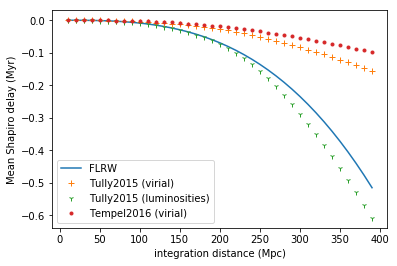

In [11]:
plt.plot(dt_Shapiro_mean[:,0],dt_Shapiro_mean[:,1]*1e-6, label='FLRW')

plt.plot(dt_Shapiro_mean_cata1[:,0],dt_Shapiro_mean_cata1[:,1]*1e-6,'+', label='Tully2015 (virial)')
plt.plot(dt_Shapiro_mean_cata2[:,0],dt_Shapiro_mean_cata2[:,1]*1e-6,'1', label='Tully2015 (luminosities)')
plt.plot(dt_Shapiro_mean_tempel[:,0],dt_Shapiro_mean_tempel[:,1]*1e-6, '.', label='Tempel2016 (virial)')

plt.xlabel('integration distance (Mpc)')
plt.ylabel('Mean Shapiro delay (Myr)')
plt.legend()
plt.savefig('cosmo_outputs/comparison_wrt_FLRW_%s_%s' % (min_dis,max_dis), dpi= 200, bbox_inches="tight")
plt.show()